# February 2021 Cablevision Mexico

1700809100 HTTP ERROR: Failure when receiving data from the peer (56)
1700809119 HTTP ERROR: Failure when receiving data from the peer (56)
1700809154 HTTP ERROR: Failure when receiving data from the peer (56)


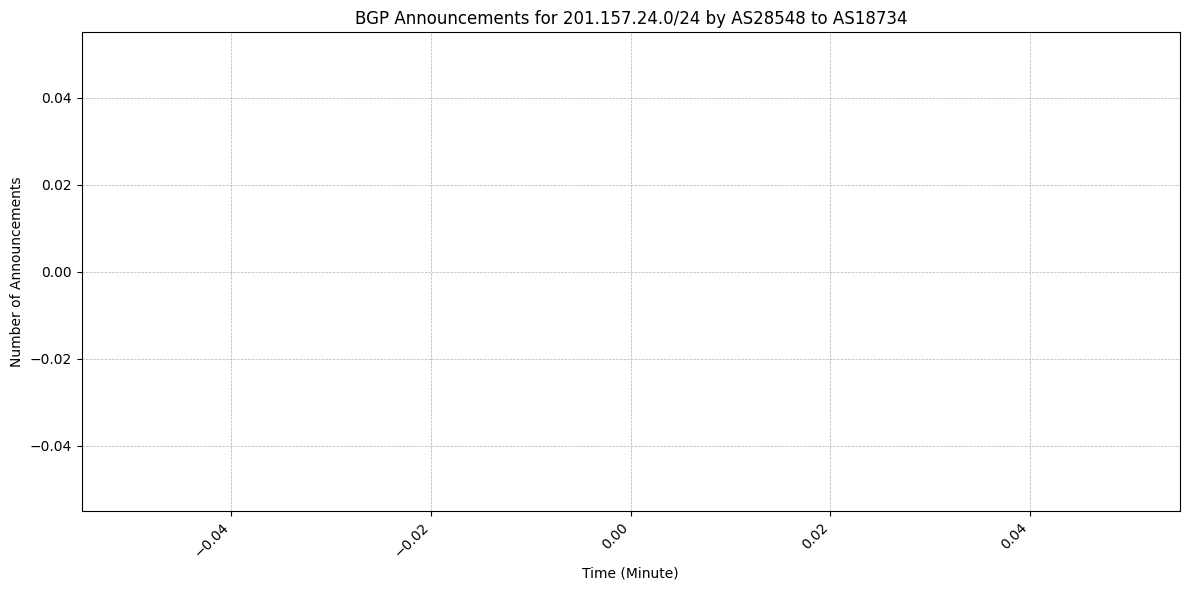

In [3]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Define the time window around the incident
start_time = "2021-02-11 00:00:00 UTC"
end_time = "2021-02-11 23:59:59 UTC"

# Target prefix and involved ASNs
target_prefix = "201.157.24.0/24"
leaking_asn = "28548"
recipient_asn = "18734"
source_asn = "14178"

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["rrc00", "route-views.wide", "route-views.peru", "route-views.linx", "route-views.saopaulo"],
    record_type="updates"
)

# Store counts of relevant BGP announcements over time
announcement_counts = defaultdict(int)

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A" and elem.fields["prefix"] == target_prefix:
            as_path = elem.fields["as-path"].split()
            # Check if the leaking ASN is announcing the prefix to the recipient ASN
            if as_path[0] == recipient_asn and leaking_asn in as_path and source_asn in as_path:
                timestamp_minute = datetime.utcfromtimestamp(rec.time).strftime('%Y-%m-%d %H:%M')
                announcement_counts[timestamp_minute] += 1

# Visualizing the announcements over time
timestamps = sorted(announcement_counts.keys())

plt.figure(figsize=(12, 6))
plt.plot(timestamps, [announcement_counts[ts] for ts in timestamps], marker='o', linestyle='-')
plt.xlabel('Time (Minute)')
plt.ylabel('Number of Announcements')
plt.title(f'BGP Announcements for {target_prefix} by AS{leaking_asn} to AS{recipient_asn}')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# April 2021: Large BGP routing leak out of India

In [2]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Define the time window around the incident
start_time = "2021-04-17 13:00:00 UTC"
end_time = "2021-04-17 15:00:00 UTC"

# AS55410 (Vodafone Idea Ltd.)
hijacking_asn = "55410"

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["route-views2", "route-views3", "route-views4", "ris-ripe"],
    record_type="updates"
)

# Store counts of unexpected announcements by AS55410
unexpected_announcements = defaultdict(int)

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            as_path = elem.fields["as-path"].split()
            # Check if AS55410 is originating routes unexpectedly
            if as_path[0] == hijacking_asn and len(as_path) > 1:  # More than one AS in path indicates a prepend
                timestamp_minute = datetime.utcfromtimestamp(rec.time).strftime('%Y-%m-%d %H:%M')
                unexpected_announcements[timestamp_minute] += 1

# Visualizing the unexpected announcements over time
timestamps = sorted(unexpected_announcements.keys())

plt.figure(figsize=(12, 6))
plt.plot(timestamps, [unexpected_announcements[ts] for ts in timestamps], marker='o', linestyle='-')
plt.xlabel('Time (Minute)')
plt.ylabel('Number of Unexpected Announcements by AS55410')
plt.title('Unexpected BGP Announcements Originating from AS55410')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()